In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchsummary import summary

class vgg19(nn.Module):
    def __init__(self, num_classes):
        super(vgg19, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(512*4*4, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        logits = self.classifier(x.view(-1, 512*4*4))
        #probas = F.softmax(logits, dim=1)
        return logits
    
#model = vgg19(num_classes=12)
#print(f"Total number of parameters: {sum(p.numel() for p in model.parameters())}")
#model = model.to('cuda')
#summary(model, input_size=(3, 128, 128), batch_size=-1, device='cuda')




In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"
import torch
if hasattr(torch.cuda, 'empty_cache'):
    torch.cuda.empty_cache()




In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import argparse
from tqdm import tqdm
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, dataloader, Subset

from torch.utils.data import random_split
from sklearn.model_selection import KFold

from torch.utils.tensorboard import SummaryWriter
#import os
#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"



# 定义是否使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# 参数设置,使得我行差们能够手动输入命令行参数，就是让风格变得和Linux命令不多
# parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Training')
# parser.add_argument('--outf', default='./model/', help='folder to output images and model checkpoints')  # 输出结果保存路径
# parser.add_argument('--net', default='./model/Resnet18.pth', help="path to net (to continue training)")  # 恢复训练时的模型路径
# args = parser.parse_args()

# 超参数设置
EPOCH = 30  # 遍历数据集次数
pre_epoch = 0  # 定义已经遍历数据集的次数
BATCH_SIZE = 64  # 批处理尺寸(batch_size)
LR = 0.001  # 学习率
val_accuracies = []

# print("开始加载CIFAR10数据集!")
# 准备数据集并预处理
transform_train = transforms.Compose([
    transforms.Resize(size=(128,128)),
    #transforms.RandomCrop(32, padding=4),  # 先四周填充0，在吧图像随机裁剪成32*32
    transforms.CenterCrop(128),
    transforms.RandomHorizontalFlip(),  # 图像一半的概率翻转，一半的概率不翻转
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  # R,G,B每层的归一化用到的均值和方差
])

transform_valid = transforms.Compose([
    transforms.Resize(size=(128,128)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# 训练数据集
train_dataset = ImageFolder(root='../input/newdata3/train/', transform=transform_train)  
#validset = ImageFolder(root='../input/corn/train/', train=False, transform=transform_valid )

num_train = int(len(train_dataset))
#num_val = len(fullset)-num_train

#train_dataset, val_dataset = random_split(fullset, [num_train,num_val])

# 定义K-fold对象
Kf_train = KFold(n_splits=5, shuffle=True, random_state=42)

# 训练数据集
#trainset = ImageFolder(root='../input/newdata/train', transform=transform_train)  
 # 生成一个个batch进行批训练，组成batch的时候顺序打乱取，
#trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True,num_workers=0) 

# 测试训练集
#validset = ImageFolder(root='../input/newdata/val/', transform=transform_valid )
#validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

print("数据集加载完毕!")

print("开始vgg网络模型初始化!")
# 模型定义-ResNet
model = vgg19(num_classes=12).to(device)

# 定义损失函数和优化方式
loss_fn = nn.CrossEntropyLoss()  # 损失函数为交叉熵，多用于多分类问题
loss_fn = loss_fn.to(device)
# 优化方式为mini-batch momentum-SGD，并采用L2正则化（权重衰减）
optimizer = optim.SGD(model.parameters(),lr=LR, momentum=0.9, weight_decay=5e-4)  

# 记录训练的次数
total_train_step = 0
# 记录测试的次数
total_test_step = 0
# 记录训练集和测试集的正确率，形成列表
total_test_acc_list = []
total_train_acc_list = []

# 添加tensorboard画图可视化
writer = SummaryWriter("../vgg19/logs_train2_none")

print("vgg19网络模型初始化完毕!")
# 训练
if __name__ == "__main__":
    best_acc = 80  # 2 初始化best test accuracy
    best_epoch = 0
    # 有需要可以打开，接着上次训练好的权重训练
    #print("加载模型...")
    #with open("../vgg19/epoch2/vgg19_none_30.pth",'rb') as f:
         #model.load_state_dict(torch.load(f))
    #print("加载完毕!")
    #print("开始训练! vgg-19! 冲!")  # 定义遍历数据集的次数

    
    for train_index, val_index in Kf_train.split(range(num_train)):
        train_kfold_subset = Subset(train_dataset, train_index)
        val_kfold_subset =Subset(train_dataset, val_index)

        trainloader = DataLoader(train_kfold_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
        validloader = DataLoader(val_kfold_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)


        for epoch in range(pre_epoch, EPOCH):
            model.train()
            print(f'--------第{epoch + 1}轮训练开始---------')
            total_train_loss = 0.0
            correct = 0.0
            total = 0.0
            for data in tqdm(trainloader):
            # print("-------",i)
            # 准备数据
               inputs, labels = data
               inputs, labels = inputs.to(device), labels.to(device)
            #梯度清零
               optimizer.zero_grad()

            # forward + backward
            # 前向传播获取网络输出信息，做损失函数的输出计算，后向传播获取梯度信息，根据学习策略优化学习
               outputs = model(inputs)
               loss = loss_fn(outputs, labels)
               loss.backward()
               optimizer.step()

            # 每训练100个batch打印一次loss和准确率
               total_train_loss += loss.item()
               _, predicted = torch.max(outputs.data, 1)
               total += labels.size(0)
               total_train_step += 1
               correct += predicted.eq(labels.data).cpu().sum()
    
               writer.add_scalar("train_loss", loss.item(), total_train_step)
            train_accurary = 100 * correct / total
            print(f'训练集正确率为:{train_accurary}')
            total_train_acc_list.append(train_accurary)


        # 每训练完一个epoch测试一下准确率
            print("开始测试!")
            model.eval()
            with torch.no_grad():
                correct = 0
                total = 0
                total_test_loss=0
                for data in tqdm(validloader):
                
                   images, labels = data
                   images, labels = images.to(device), labels.to(device)
                   outputs = model(images)
                   loss = loss_fn(outputs, labels)
                   total_test_loss += loss.item()
                # 取得分最高的那个类 (outputs.data的索引号)
                   _, predicted = torch.max(outputs.data, 1)
                # labels是一个尺寸为 的张量[N, 1]，其中N等于批次中的样本数。
                   total += labels.size(0)
                   correct += (predicted == labels).sum().item()
                # result = torch.floor_divide(correct, total)
            # print('测试分类准确率为：%.3f%%' % (100 * result))
                acc = 100 * correct / total
                print(f"测试集上的loss：{total_test_loss}")
                print(f'测试分类准确率为：{acc}')
           
            # 将每次测试结果实时写入acc.txt文件中
                print('Saving model......')
                torch.save(model.state_dict(), f'../vgg19/epoch2/vgg19_{epoch + 1}.pth')
                writer.add_scalar("test_loss", total_test_loss, total_test_step)
                total_test_step = total_test_step + 1
                total_test_acc_list.append(acc)
            # 记录最佳测试分类准确率并写入best_acc.txt文件中
                if acc > best_acc:
                   f3 = open("../vgg19/best_acc2_5kfold.txt", "w")
                   f3.write(f"训练轮次为{epoch + 1}时,准确率最高!准确率为{acc}")
                   f3.close()
                   best_acc = acc
            val_accuracies.append(best_acc)
        print("训练结束!")

average_val_accuracy = sum(val_accuracies) / len(val_accuracies)

print(f"Average Validation Accuracy: {average_val_accuracy:.4f}")

for i in range(len(total_test_acc_list)):
    with open('../vgg19/vgg19_acc2_5kfold.txt', 'a') as f:
        f.write('%d %.3f %.3f\n' % (i+1,total_train_acc_list[i],total_test_acc_list[i]))
#     with open('skip18_train_accura/te_records_k.txt', 'a') as f:
#         f.write('%d %.3f\n' % (i+1,total_train_accuracy_list[i]))
torch.save(model.state_dict(),"../vgg19/vgg19_2_acc_5kfold.pkl")



In [ ]:
print(f"Average Validation Accuracy: {average_val_accuracy:.4f}")

seed is 121
cuda


100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


score_array: (548, 12)
label_onehot: (548, 12)
(549,) (549,) 0.7980336102483062
(549,) (549,) 0.9962962962962965
(549,) (549,) 0.9578143263023502
(549,) (549,) 0.9774930250084106
(549,) (549,) 0.9874267806267807
(549,) (549,) 0.998081228014071
(549,) (549,) 0.9421800032302394
(549,) (549,) 1.0000000000000002
(549,) (549,) 0.9829636182162765
(549,) (549,) 0.9474237464092535
(549,) (549,) 0.9893054554193705
(549,) (549,) 0.9936451001800278
Average precision score, micro-averaged over all classes: 0.9721
Accuracy of Black-grass : 66.667 %
Accuracy of Charlock : 100.000 %
Accuracy of Cleavers : 93.939 %
Accuracy of Common Chickweed : 97.183 %
Accuracy of Common wheat : 92.000 %
Accuracy of Fat Hen : 100.000 %
Accuracy of Loose Silky-bent : 89.474 %
Accuracy of Maize : 100.000 %
Accuracy of Scentless Mayweed : 96.667 %
Accuracy of Shepherd Purse : 96.296 %
Accuracy of Small-flowered Cranesbill : 96.491 %
Accuracy of Sugar beet : 100.000 %
[[20  0  0  0  1  0  9  0  0  0  0  0]
 [ 0 45  0  0

<Figure size 640x480 with 0 Axes>

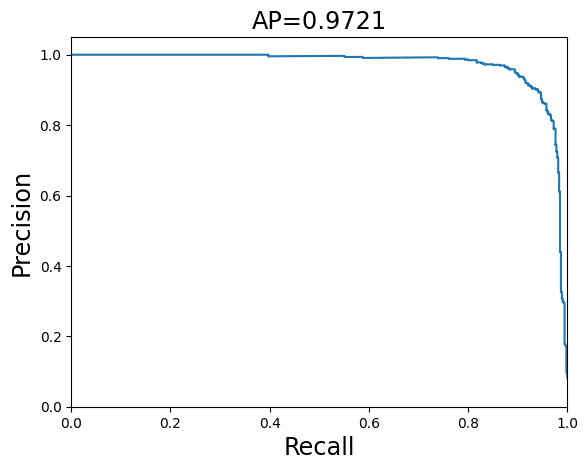

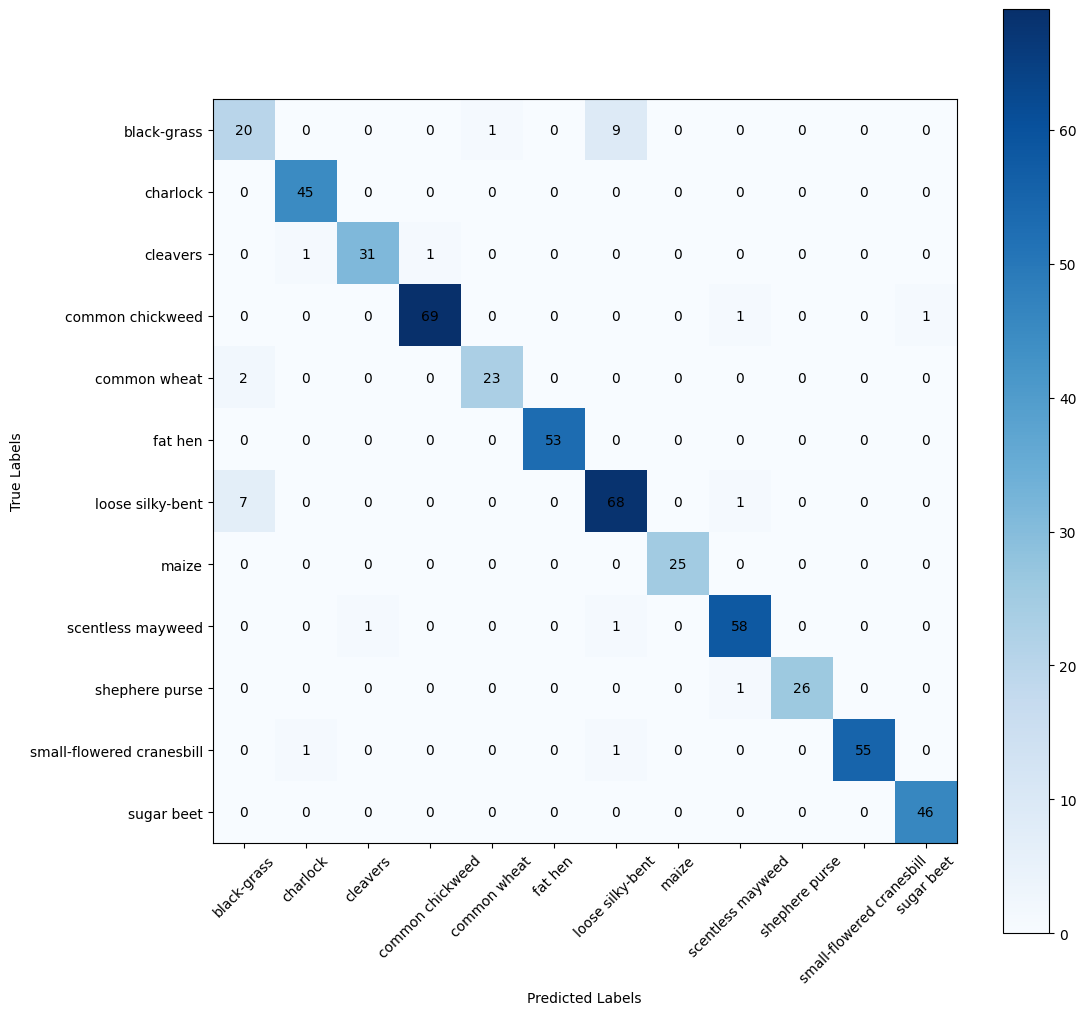

In [2]:
# 使用cifar10数据集，跳跃网络

from numpy import log2
import torch
import torch.nn.functional as F
from torch.nn.modules import flatten
from torch.nn.modules.flatten import Flatten
from torch.nn.modules.pooling import MaxPool2d
import torchvision
from torch.utils.data import DataLoader, dataloader
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import time
import random

import numpy as np
from torchvision import transforms
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import torch.optim as optim
from torchvision.datasets import ImageFolder
import os
from sklearn.metrics import roc_curve, auc, f1_score,precision_recall_curve,average_precision_score
# import seaborn as sns
# from resnet_skip import ResNet_Skip

seed_n = 121
print('seed is ' + str(seed_n))
g = torch.Generator()
g.manual_seed(seed_n)
random.seed(seed_n)
np.random.seed(seed_n)
torch.manual_seed(seed_n)
torch.cuda.manual_seed(seed_n)
torch.cuda.manual_seed_all(seed_n)
            # torch.backends.cudnn.deterministic=True
            # torch.backends.cudnn.benchmark = False
            # torch.backends.cudnn.enabled = False
            # torch.use_deterministic_algorithms(True)
            # os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'
os.environ['PYTHONHASHSEED'] = str(seed_n)  # 为了禁止hash随机化，使得实验可复现。

# torch.manual_seed(1)
#transform_train = transforms.Compose([
#    transforms.Resize(size=(128,128)),
    #transforms.RandomCrop(32, padding=4),  # 先四周填充0，在吧图像随机裁剪成32*32
    #transforms.RandomHorizontalFlip(),  # 图像一半的概率翻转，一半的概率不翻转
#    transforms.ToTensor(),
#    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  # R,G,B每层的归一化用到的均值和方差
#])

transform_test = transforms.Compose([
    transforms.Resize(size=(128,128)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# 训练数据集
#trainset = ImageFolder(root='../input/newdata/train', transform=transform_train)  
#trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True,num_workers=0) 

# 测试训练集
testset = ImageFolder(root='../input/newdata3/test/', transform=transform_test )
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True, num_workers=0)




#数据集长度
#train_data_size = len(trainset)
test_data_size = len(testset)
#print("cifar10训练集长度：{}".format(train_data_size))
#print("cifar10测试集长度：{}".format(test_data_size))


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

#创建网络模型
# test_net = skip_net_mnist()
# test_net = SkipNetC2()
test_net = vgg19(num_classes=12)
# if torch.cuda.device_count() > 1:
#   print("Let's use", torch.cuda.device_count(), "GPUs!")
#   test_net = nn.DataParallel(test_net)

# ../input/skipnetmodel/skip_net_CIFAR10_164 (3)
#test_net.load_state_dict(torch.load("/home/featurize/work/(1)—3k_nopre_mish_Skipnet18_0_50_128_0.01.pkl"))
test_net.load_state_dict(torch.load("../vgg19/vgg19_2_acc_5kfold.pkl"))

test_net.to(device)
#创建损失函数
loss_fn = torch.nn.CrossEntropyLoss()
loss_fn.to(device)
#创建优化器
learning_rata = 0.001
#learning_rata = 0.01#或者使用1e-2代替0.01
optimizer = optim.SGD(test_net.parameters(),lr=learning_rata, momentum=0.9, weight_decay=5e-4)

num_classes = 12

plt.figure()

# 存储预测得分
score_list = []
# 存储真实标签
label_list = []
#训练的次数
total_train_step = 0
#测试次数
total_test_step = 0
total_train_accuracy = 0
# Decey_x = 0.5
total_train_accuracy_list = []
total_test_accuracy_list = []

total_accuracy = 0
#测试步骤
test_net.eval()
total_test_loss = 0
total_test_step = 0
# 测试模型
correct = [0] * 12
total = [0] * 12
y_pred = []
y_true = []
with torch.no_grad():
    for data in tqdm(testloader):
        images, labels = data
        images = images.to(device)
        # images = images.view(-1,3,32,32)
        labels = labels.to(device)

        outputs = test_net(images)
        score_temp = outputs
        score_list.extend(score_temp.detach().cpu().numpy())
        label_list.extend(labels.cpu().numpy())

        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.tolist())
        y_true.extend(labels.tolist())
        for i in range(len(labels)):
            label = labels[i]
            total[label] += 1
            if predicted[i] == label:
                correct[label] += 1

    score_array = np.array(score_list)
    # 将label转换为onehot形式
    label_tensor = torch.tensor(label_list)
    label_tensor = label_tensor.reshape((label_tensor.shape[0],1))
    label_onehot = torch.zeros(label_tensor.shape[0], num_classes)
    label_onehot.scatter_(dim=1, index=label_tensor, value=1)
    label_onehot = np.array(label_onehot)
    print("score_array:", score_array.shape)
    print("label_onehot:", label_onehot.shape)

    #调用sklearn库，计算每个类别对应的precision和recall
    precision_dict = dict()
    recall_dict = dict()
    average_precision_dict = dict()
    for i in range(num_classes):
        precision_dict[i], recall_dict[i], _ = precision_recall_curve(label_onehot[:, i], score_array[:, i])
        average_precision_dict[i] = average_precision_score(label_onehot[:, i], score_array[:, i])
        print(precision_dict[i].shape, recall_dict[i].shape, average_precision_dict[i])

    # micro
    precision_dict["micro"], recall_dict["micro"], _ = precision_recall_curve(label_onehot.ravel(),
                                                                              score_array.ravel())
    average_precision_dict["micro"] = average_precision_score(label_onehot, score_array, average="micro")
    print('Average precision score, micro-averaged over all classes: {0:0.4f}'.format(average_precision_dict["micro"]))
 
    # 绘制所有类别平均的pr曲线
    plt.figure()
    plt.step(recall_dict['micro'], precision_dict['micro'], where='post')
 
    plt.xlabel('Recall',fontsize='xx-large')
    plt.ylabel('Precision',fontsize='xx-large')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(
        'AP={0:0.4f}'
        .format(average_precision_dict["micro"]),fontsize='xx-large')
    plt.savefig("../vgg19/set12_pr_curve.jpg")

# 输出每个类别的准确率
for i in range(12):
    print('Accuracy of %5s : %.3f %%' % (
        testset.classes[i], 100 * correct[i] / total[i]))


# 将预测结果转换为标签
y_pred_labels = np.array(y_pred)

# 计算混淆矩阵
cm = confusion_matrix(y_true, y_pred_labels)

print(cm)


# 绘制混淆矩阵
# plt.figure(figsize=(10, 8))
# sns.set(font_scale=1.4)
# sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.show()
# 绘制混淆矩阵
plt.figure(figsize=(12,12))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
# 添加数值
for i in range(12):
    for j in range(12):
        plt.annotate(str(cm[i][j]), xy=(j, i), horizontalalignment='center', verticalalignment='center')

plt.colorbar()
tick_marks = np.arange(12)
plt.xticks(tick_marks, ['black-grass', 'charlock', 'cleavers', 'common chickweed','common wheat','fat hen', 'loose silky-bent', 'maize', 'scentless mayweed', 'shephere purse', 'small-flowered cranesbill','sugar beet'], rotation=45)
plt.yticks(tick_marks, ['black-grass', 'charlock', 'cleavers', 'common chickweed','common wheat','fat hen', 'loose silky-bent', 'maize', 'scentless mayweed', 'shephere purse', 'small-flowered cranesbill','sugar beet'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
# plt.show()
plt.savefig('../vgg19/confusion_matrixA_5fold.png')
        


In [3]:
from sklearn.metrics import classification_report

# 计算准确率、召回率、精确率和 F1 值
target_names = ['black-grass', 'charlock', 'cleavers', 'common chickweed','common wheat','fat hen', 'loose silky-bent', 'maize', 'scentless mayweed', 'shephere purse', 'small-flowered cranesbill','sugar beet']
print(classification_report(y_true, y_pred_labels, target_names=target_names,digits=5))

                           precision    recall  f1-score   support

              black-grass    0.68966   0.66667   0.67797        30
                 charlock    0.95745   1.00000   0.97826        45
                 cleavers    0.96875   0.93939   0.95385        33
         common chickweed    0.98571   0.97183   0.97872        71
             common wheat    0.95833   0.92000   0.93878        25
                  fat hen    1.00000   1.00000   1.00000        53
         loose silky-bent    0.86076   0.89474   0.87742        76
                    maize    1.00000   1.00000   1.00000        25
        scentless mayweed    0.95082   0.96667   0.95868        60
           shephere purse    1.00000   0.96296   0.98113        27
small-flowered cranesbill    1.00000   0.96491   0.98214        57
               sugar beet    0.97872   1.00000   0.98925        46

                 accuracy                        0.94708       548
                macro avg    0.94585   0.94060   0.94302    